In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def sector_data(sector_page_link):
    response = requests.get(sector_page_link)
    results_page = BeautifulSoup(response.content, 'lxml')
    
    sector_change = results_page.find('div', class_='tab-content-wrapper').find_all('span')[1].get_text()
    sector_market_cap = results_page.find('div', class_='tab-content-wrapper').find_all('span')[3].get_text()
    sector_market_weight = results_page.find('div', class_='tab-content-wrapper').find_all('span')[5].get_text()
    
    return sector_change, sector_market_cap, sector_market_weight

def sector_performance():
    stats_list = list()
    sector_list = list()
    measure_list = list()

    url = "https://eresearch.fidelity.com/eresearch/goto/markets_sectors/landing.jhtml"

    results_page = requests.get(url)
    soup = BeautifulSoup(results_page.content, 'lxml')
    all_performance = soup.find_all('a', class_='heading1')

    for sectors in all_performance:
        name = sectors.find('strong').get_text()
        link = "https://eresearch.fidelity.com" + sectors.get('href')
        change, mktcap, mktwgt = sector_data(link)
        stats_list.append((change, mktcap, mktwgt))
        sector_list.append(name)

    measure_list = 'Sector_Change', 'Market_Capital', 'Market_Weight'
    sector_table = pd.DataFrame(stats_list, index = sector_list, columns = measure_list)
    
    return sector_table

# Sector performance from Fidelity
sector_performance()

,Sector_Change,Market_Capital,Market_Weight
Communication Services,+0.07%,$4.46T,9.80%
Consumer Discretionary,-0.32%,$4.73T,9.73%
Consumer Staples,+0.20%,$3.41T,7.50%
Energy,+0.72%,$3.47T,5.51%
Financials,-0.72%,$7.16T,13.82%
Health Care,+0.60%,$5.66T,15.61%
Industrials,-0.03%,$3.89T,9.51%
Information Technology,-0.86%,$6.85T,19.70%
Materials,+0.58%,$1.76T,2.67%
Real Estate,+0.29%,$1.20T,2.95%


In [1]:
stock = input('Enter a stock ticker: ').upper()

Enter a stock ticker: jd


In [96]:
def get_sector(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://finance.yahoo.com/quote/' + ticker + '/profile?p=' + ticker

    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    profile = results_page.find('div', class_='asset-profile-container')
    sector = profile.find_all('strong')[0].get_text()
    industry = profile.find_all('strong')[1].get_text()

    return sector, industry
# sector and industry from Yahoo Finance
get_sector(stock)

('Consumer Cyclical', 'Specialty Retail')

### Find competitors

In [3]:
def get_competitors(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://www.nasdaq.com/symbol/' + ticker + '/stock-comparison'

    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    table = results_page.find('div', class_='genTable thin')
    competitors = list()
    for i in range(4):
        competitors.append(table.find_all('input')[i].get('value'))
    
    return competitors
    
get_competitors(stock)

['ORLY', 'AZO', 'ULTA', 'IAC']

In [4]:
def get_financial_stats(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = "https://finance.yahoo.com/quote/" + ticker + "/key-statistics?p=" + ticker
    
    response = requests.get(url)
    results_page = BeautifulSoup(response.content,'lxml')
    stats_lists = results_page.find_all('table')
    test_list = list()
    for i in stats_lists:
        stat_name = i.find_all('span')
        stock_stat = i.find_all('td',class_='Fz(s) Fw(500) Ta(end)')
        for j in range(len(stock_stat)):
            if not stat_name[j].get_text() == 'N/A':
                test_list.append((stat_name[j].get_text(),stock_stat[j].get_text()))
    return test_list

In [53]:
def get_row(ticker,measure_list):
    from pandas_datareader import data as web
    a = get_financial_stats(ticker)
    row = list()
    row.append(web.DataReader(ticker,"yahoo").iloc[-1,3])
    for i in measure_list:
        if not i == "Price":
            appended = 0
            for j in a:
                if j[0] == i:
                    row.append(j[1])
                    appended = 1
            if appended == 0:
                row.append('N/A')   
    return row

In [95]:
# def competitor(ticker)
import numpy as np

r = get_competitors(stock)
r.insert(0, stock)

for i in range(0,len(r)):
    m = list((1,2,3,4,5))
    if get_row(r[i],['Market Cap (intraday)'])[1][-1] == 'T':
        m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1]) * 1000
    elif get_row(r[i],['Market Cap (intraday)'])[1][-1] == 'M':
        m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1]) / 1000
    else:
        m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1])

for i in range(1,len(r)):
    diff = list()
    diff.append(abs(m[0]-m[i]))

r[np.argmin(diff)+1]

'ORLY'

### Comparison Table

In [56]:
def comp_stat_table(ticker):
    import pandas as pd
    measure_list = ['Price','Market Cap (intraday)','Diluted EPS','Book Value Per Share','Quarterly Revenue Growth','Quarterly Earnings Growth','Trailing Annual Dividend Yield','5 Year Average Dividend Yield','Payout Ratio','Trailing P/E','PEG Ratio (5 yr expected)','Beta (3Y Monthly)']
    r = get_competitors(ticker)
    r.insert(0, ticker)

    s_row = get_row(stock,measure_list)
    a_row = get_row(r[1],measure_list)
    b_row = get_row(r[2],measure_list)
    c_row = get_row(r[3],measure_list)
    d_row = get_row(r[4],measure_list)

    stats_list = [s_row,a_row,b_row,c_row,d_row]
    final_table = pd.DataFrame(stats_list,index = r,columns = measure_list)
    return final_table
comp_stat_table(stock)

,Price,Market Cap (intraday),Diluted EPS,Book Value Per Share,Quarterly Revenue Growth,Quarterly Earnings Growth,Trailing Annual Dividend Yield,5 Year Average Dividend Yield,Payout Ratio,Trailing P/E,PEG Ratio (5 yr expected),Beta (3Y Monthly)
JD,21.230000,30.72B,-0.06,6.12,31.20%,N/A,N/A,N/A,N/A,N/A,0.49,1.38
ORLY,346.779999,27.78B,15.89,6.20,6.10%,29.00%,N/A,1/2,N/A,21.83,1.29,1.21
AZO,809.070007,20.68B,48.77,N/A,1.30%,-7.70%,N/A,1/2,N/A,16.59,1.32,1.06
ULTA,297.790009,17.8B,10.25,N/A,15.40%,29.90%,"May 15, 2012",N/A,N/A,29.06,1.35,0.85
IAC,177.960007,14.86B,4.96,31.15,33.30%,-18.90%,0.00%,"Dec 1, 2015",2/1,35.86,1.82,1.58


In [26]:
import datetime
import dateutil.relativedelta
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

stocks = stock, get_competitors(stock)
three_years_ago = (datetime.date.today() - dateutil.relativedelta.relativedelta(years=3)).strftime('%Y-%m-%d')
today = datetime.date.today().strftime('%Y-%m-%d')


prices = web.DataReader(np.hstack(('SPY',)+stocks),'yahoo',three_years_ago,today)['Adj Close']
returns = prices.pct_change() # daily returns
returns.corr()['SPY'] # correlation between each stock and S&P 500

Symbols
AZO     0.308183
IAC     0.451685
JD      0.469157
ORLY    0.352187
SPY     1.000000
ULTA    0.332500
Name: SPY, dtype: float64

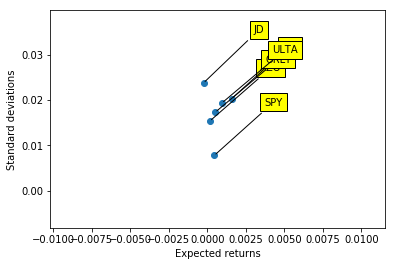

In [23]:
plt.xlabel('Expected returns')
plt.ylabel('Standard deviations')
for label,x,y in zip(returns.columns,returns.mean(),returns.std()):
    plt.annotate(
        label, 
        xy = (x,y),
        xytext = (50,50),
        textcoords = 'offset points',
        bbox = dict(fc = 'yellow'),
        arrowprops = dict(arrowstyle = '-')
    )
plt.scatter(returns.mean(), returns.std())

                            OLS Regression Results                            
Dep. Variable:                     JD   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     314.1
Date:                Sat, 01 Dec 2018   Prob (F-statistic):           5.00e-59
Time:                        15:28:22   Log-Likelihood:                -2503.8
No. Observations:                 757   AIC:                             5012.
Df Residuals:                     755   BIC:                             5021.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3582      1.782      0.762      0.4

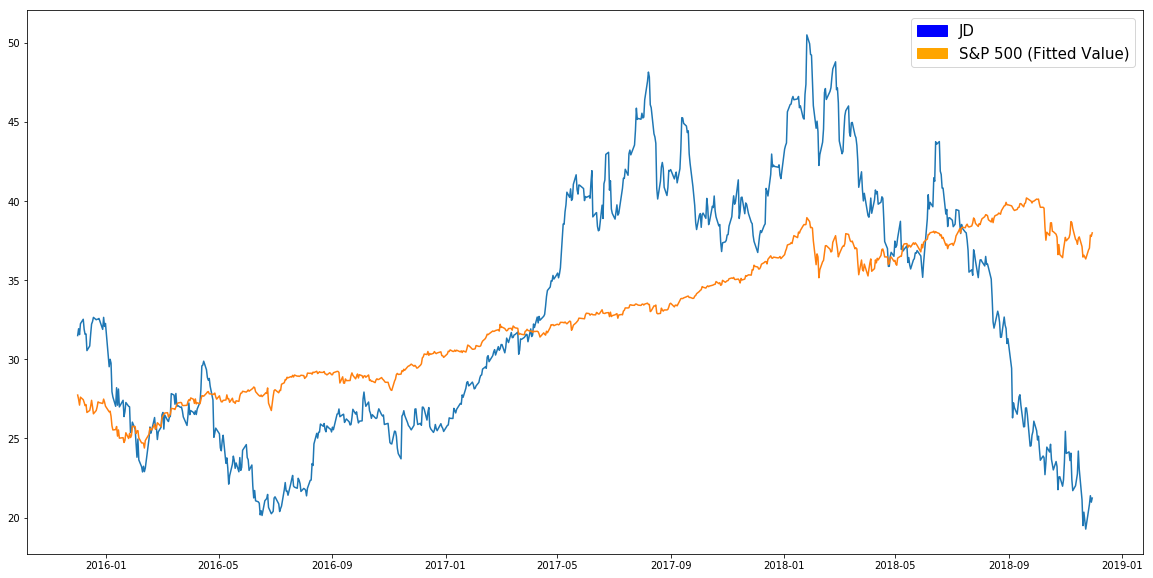

In [92]:
import matplotlib.patches as mpatches
import pylab as plot
x = prices['SPY']
x = sm.add_constant(x)
y = prices[stock]
model = sm.OLS(y,x,missing='drop')
regression = model.fit()
print(regression.summary())
fig,ax = plt.subplots(figsize=(20,10))

blue_patch = mpatches.Patch(color='blue', label=stock)
orange_patch = mpatches.Patch(color='orange', label='S&P 500 (Fitted Value)')
plt.legend(handles=[blue_patch,orange_patch])
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

ax.plot(y) # blue
ax.plot(regression.fittedvalues) # orange

In [ ]:
import matplotlib.patches as mpatches
import pylab as plot
x = prices['SPY']
x = sm.add_constant(x)
y = prices[stock]
model = sm.OLS(y,x,missing='drop')
regression = model.fit()
print(regression.summary())
fig,ax = plt.subplots(figsize=(20,10))

blue_patch = mpatches.Patch(color='blue', label=stock)
orange_patch = mpatches.Patch(color='orange', label='S&P 500 (Fitted Value)')
plt.legend(handles=[blue_patch,orange_patch])
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

ax.plot(y) # blue
ax.plot(regression.fittedvalues) # orange